In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mehradaria/leukemia")

print("Path to dataset files:", path)

100%|██████████| 110M/110M [00:02<00:00, 40.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mehradaria/leukemia/versions/1


In [2]:
# =========================================
# 1. MOUNT GOOGLE DRIVE
# =========================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# =========================================
# 2. INSTALL KAGGLE (if not already)
# =========================================
!pip install kaggle --quiet

# =========================================
# 3. AUTHENTICATE KAGGLE
#    Make sure you have kaggle.json in your Drive
#    e.g., /content/drive/MyDrive/kaggle.json
# =========================================
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# =========================================
# 4. DOWNLOAD THE LEUKEMIA DATASET FROM KAGGLE
#    Correct dataset path for 'mehradaria/leukemia'.
#    This will create 'leukemia.zip' in your Colab environment.
# =========================================
!kaggle datasets download -d mehradaria/leukemia

# =========================================
# 5. UNZIP THE DOWNLOADED ZIP FILE
#    Adjust the .zip filename if needed; by default, 'leukemia.zip'
#    is created. We'll unzip into /content/data.
# =========================================
!unzip -q leukemia.zip -d /content/data

# =========================================
# 6. VERIFY YOUR DATA FOLDER STRUCTURE
#    Feel free to adjust directory checks or run your own listings.
# =========================================
import os

base_dir = '/content/data'
print("Contents of base_dir:")
print(os.listdir(base_dir))

Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia
License(s): ODbL-1.0
 79% 87.0M/110M [00:00<00:00, 313MB/s]
100% 110M/110M [00:00<00:00, 265MB/s] 
Contents of base_dir:
['Segmented', 'Original']


In [6]:
import os

base_dir = '/content/data/Original'
for category in ['Benign', 'Early', 'Pre', 'Pro']:
    folder_path = os.path.join(base_dir, category)
    print(category, ":", len(os.listdir(folder_path)), "images")


Benign : 504 images
Early : 985 images
Pre : 963 images
Pro : 804 images


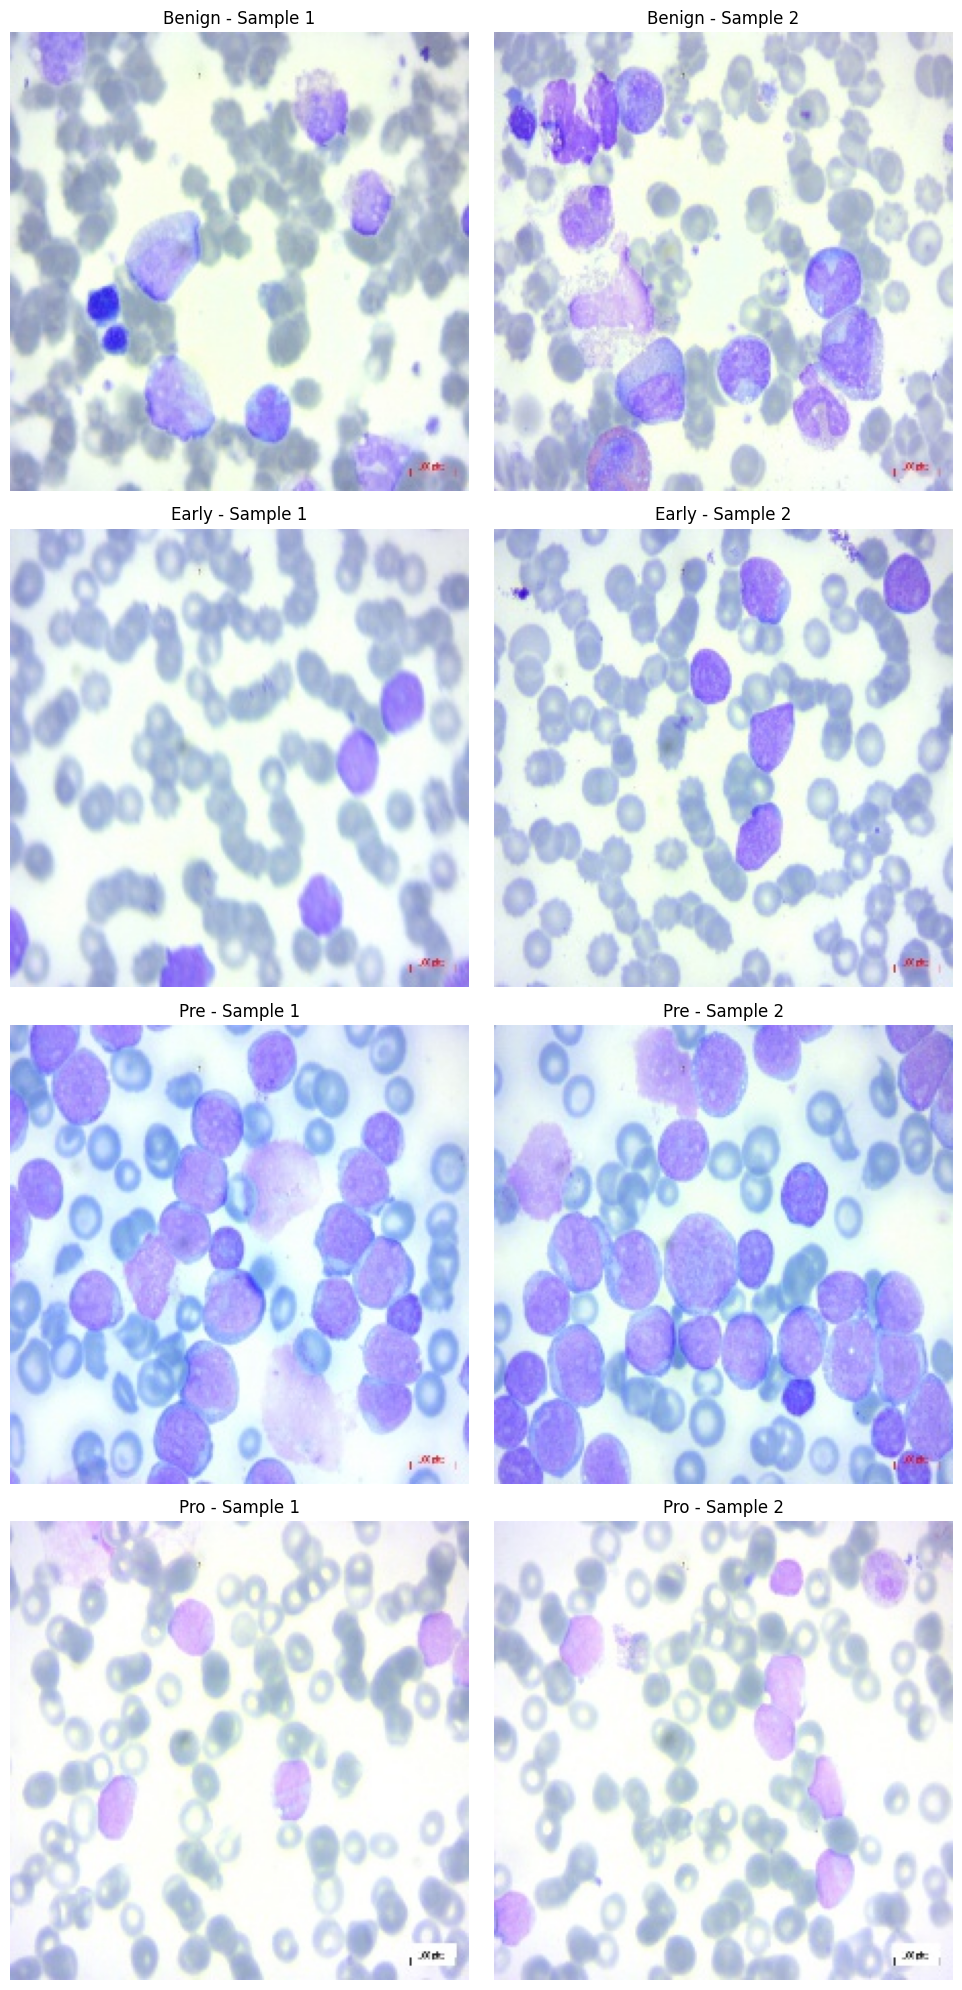

In [7]:
import os
import matplotlib.pyplot as plt
import cv2
import random


categories = ['Benign', 'Early', 'Pre', 'Pro']

# Number of samples to display per category
samples_per_category = 2  # You can adjust this number as needed

plt.figure(figsize=(samples_per_category * 5, len(categories) * 5))  # Adjust figure size based on samples

for i, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)

    # Check if the category directory exists
    if not os.path.isdir(category_path):
        print(f"Directory for category '{category}' does not exist at path: {category_path}")
        continue

    # List all image files in the category directory
    images = [file for file in os.listdir(category_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Check if there are images in the category
    if not images:
        print(f"No images found in category '{category}' at path: {category_path}")
        continue

    # Randomly select samples to display
    selected_images = random.sample(images, min(samples_per_category, len(images)))

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(category_path, image_name)
        img = cv2.imread(img_path)

        # Check if the image was successfully loaded
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        # Convert BGR (OpenCV format) to RGB (Matplotlib format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Calculate subplot position
        # Rows = number of categories, Columns = samples_per_category
        subplot_position = i * samples_per_category + j + 1
        plt.subplot(len(categories), samples_per_category, subplot_position)
        plt.imshow(img)
        plt.title(f"{category} - Sample {j+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

# Assuming base_dir is already defined and points to the dataset directory
# base_dir = 'path_to_your_dataset'  # Defined in a previous code block

# Define categories (ensure these match your directory names)
categories = ['Benign', 'Early', 'Pre', 'Pro']

# Parameters
batch_size = 16
target_size = (224, 224)
validation_split = 0.2
random_seed = 42  # For reproducibility

# Training Data Generator with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Data Generator without Data Augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # Fixed syntax by adding comma
    seed=random_seed
)

# Validation Generator
val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,  # Typically, validation data is not shuffled
    seed=random_seed
)

# Optional: Print class indices to verify correct mapping
print("Class Indices:", train_generator.class_indices)

# Optional: Compute Class Weights to Handle Class Imbalance
# This assumes you have access to the labels from train_generator
# If classes are balanced, this step can be skipped
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.
Class Indices: {'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
Class Weights: {0: 1.6132425742574257, 1: 0.8270939086294417, 2: 0.8453307392996109, 3: 1.0120341614906831}


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_cnn_model(input_shape=(224, 224, 3), num_classes=4):
    weight_decay = 1e-4  # L2 regularization factor

    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        # Global Average Pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # Fully Connected Layers
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model with a lower learning rate for Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_cnn_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 128)         │              

 Total params: 323,876 (1.24 MB)

 Trainable params: 322,468 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

Class Distribution:
Class 0: 404 samples
Class 1: 788 samples
Class 2: 771 samples
Class 3: 644 samples
Computed Class Weights: {0: 1.6132425742574257, 1: 0.8270939086294417, 2: 0.8453307392996109, 3: 1.0120341614906831}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 328ms/step - accuracy: 0.7633 - loss: 0.7265 - val_accuracy: 0.2465 - val_loss: 1.4526 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - accuracy: 0.9206 - loss: 0.3149 - val_accuracy: 0.2080 - val_loss: 1.6751 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.9372 - loss: 0.2480 - val_accuracy: 0.5300 - val_loss: 1.1713 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.9646 - loss: 0.1899 - val_accuracy: 0.7211 - val_loss: 0.8846 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.9528 - loss: 0.2012 - val_accuracy: 0.7658 - val_loss: 0.9111 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 219ms/step - accuracy: 0.9470 - loss: 0.2290 - val_accuracy: 0.9060 - val_loss: 0.4545 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - 

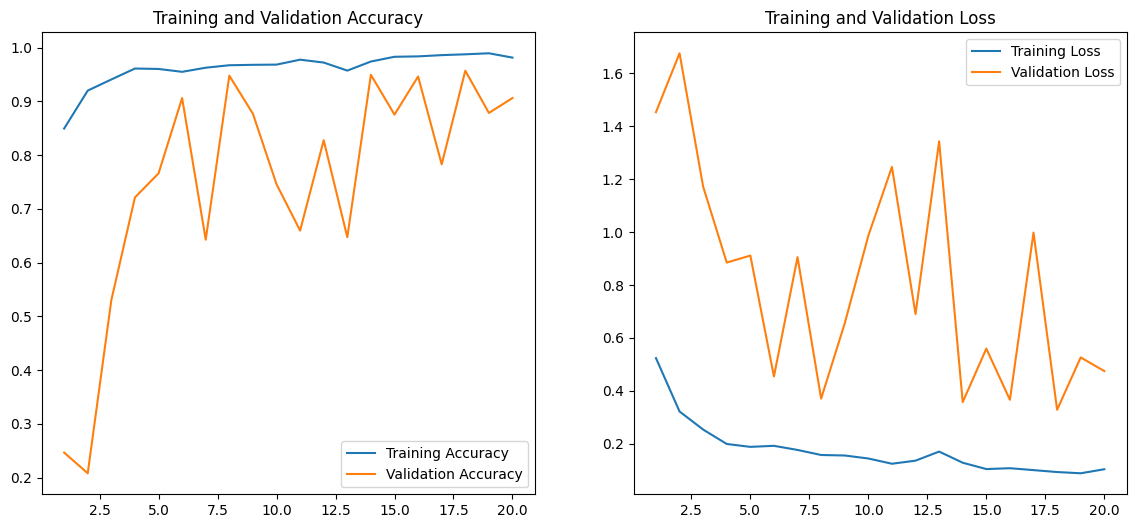

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

# Parameters
EPOCHS = 20
BATCH_SIZE = 16
PATIENCE_ES = 10  # Patience for EarlyStopping
PATIENCE_RLR = 5  # Patience for ReduceLROnPlateau

# Define the path for TensorBoard logs
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# 1. Compute Class Weights (Handle Class Imbalance)
unique_classes, counts = np.unique(train_generator.classes, return_counts=True)
print("Class Distribution:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_generator.classes
)
class_weights_dict = dict(zip(unique_classes, class_weights))
print("Computed Class Weights:", class_weights_dict)

# 2. Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE_ES,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=PATIENCE_RLR,
    verbose=1,
    min_lr=1e-6
)

# Note: ModelCheckpoint is removed to avoid the 'save_format' error

# 3. Compile the Model (Ensure Compilation with Optimizer and Loss)
# Assuming 'model' is already built and compiled as per previous steps

# 4. Fit the Model with Callbacks and Class Weights
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, tensorboard_callback],  # ModelCheckpoint removed
    class_weight=class_weights_dict  # Include if class imbalance is present
)

# 5. Visualize Training History
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

In [11]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9589 - loss: 0.2648
Validation Loss: 0.328689843416214
Validation Accuracy: 0.9568567276000977


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation/test set
y_preds = model.predict(val_generator)
# Convert predictions to class indices
y_pred_classes = np.argmax(y_preds, axis=1)
# True labels
y_true = val_generator.classes

# Class labels mapping (e.g., {'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3})
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
              precision    recall  f1-score   support

      Benign       0.97      0.94      0.95       100
       Early       1.00      0.99      1.00       197
         Pre       0.96      0.95      0.95       192
         Pro       0.90      0.93      0.91       160

    accuracy                           0.96       649
   macro avg       0.96      0.95      0.95       649
weighted avg       0.96      0.96      0.96       649

Confusion Matrix:
[[ 94   0   0   6]
 [  0 196   0   1]
 [  0   0 182  10]
 [  3   0   8 149]]


In [13]:
model.save("blood_cancer_detector.keras")


In [14]:
# Optionally copy the model file to Google Drive
!cp blood_cancer_detector.keras /content/drive/MyDrive/


In [15]:
from tensorflow.keras.models import load_model

loaded_model = load_model("blood_cancer_detector.keras")

# Verify by running an evaluation
loss, acc = loaded_model.evaluate(val_generator, verbose=0)
print(f"Loaded model accuracy: {acc}")


Loaded model accuracy: 0.9568567276000977
